# Imports

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ipyplot
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# EDA

In [8]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [9]:
def display_images(images, labels, with_tabs=False):
    class_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    labels = [class_names[label] for label in labels]

    if with_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=10, img_width=150)
    else:
        ipyplot.plot_images(images, labels, max_images=20)

display_images(x_train[:20], y_train[:20])

In [10]:
display_images(x_train[:30], y_train[:30], with_tabs=True)

In [10]:
def save_images(images, labels, save_dir="../../datasets/images/fashion_mnist"):
    os.makedirs(save_dir, exist_ok=True)
    class_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    label_names = [class_names[label] for label in labels]

    for i, image in enumerate(images):
        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(image)
        
        # Generate a filename based on class name and index
        filename = f"{label_names[i]}_{i + 1}.png"
        
        # Save the image in the specified folder
        pil_image.save(os.path.join(save_dir, filename))
    
    print(f"Images saved in the folder: {save_dir}")

save_images(x_train[:10000], y_train[:10000])

Images saved in the folder: ../../datasets/images/fashion_mnist


In [11]:
print(f"Min pixel value: {x_train.min()}")
print(f"Max pixel value: {x_train.max()}") 

Min pixel value: 0
Max pixel value: 255


# Preprocessing, training and evaluation

In [13]:
# Normalization and reshaping to add channel dimension
x_train = x_train.reshape((-1,28,28,1)).astype("float32") / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype("float32") / 255.0

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [25]:
# Data augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=20,     # Randomly rotate images by 20 degrees
    width_shift_range=0.2, # Randomly shift images horizontally by 20%
    height_shift_range=0.2,# Randomly shift images vertically by 20%
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill the newly created pixels with the nearest value
)

datagen.fit(x_train)

In [55]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - accuracy: 0.5538 - loss: 1.2065 - val_accuracy: 0.7545 - val_loss: 0.6490
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.7286 - loss: 0.7197 - val_accuracy: 0.7936 - val_loss: 0.5442
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.7660 - loss: 0.6229 - val_accuracy: 0.8081 - val_loss: 0.5146
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.7895 - loss: 0.5689 - val_accuracy: 0.8276 - val_loss: 0.4626
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.7984 - loss: 0.5361 - val_accuracy: 0.8317 - val_loss: 0.4566
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.8113 - loss: 0.5033 - val_accuracy: 0.8380 - val_loss: 0.4368
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.8207 - loss: 0.4771 - val_accuracy: 0.8445 - val_loss: 0.4346
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.8245 - loss: 0.4630 - 

In [57]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

313/313 - 1s - 3ms/step - accuracy: 0.8672 - loss: 0.3624
Test loss: 0.3624134659767151
Test accuracy: 0.8672000169754028


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


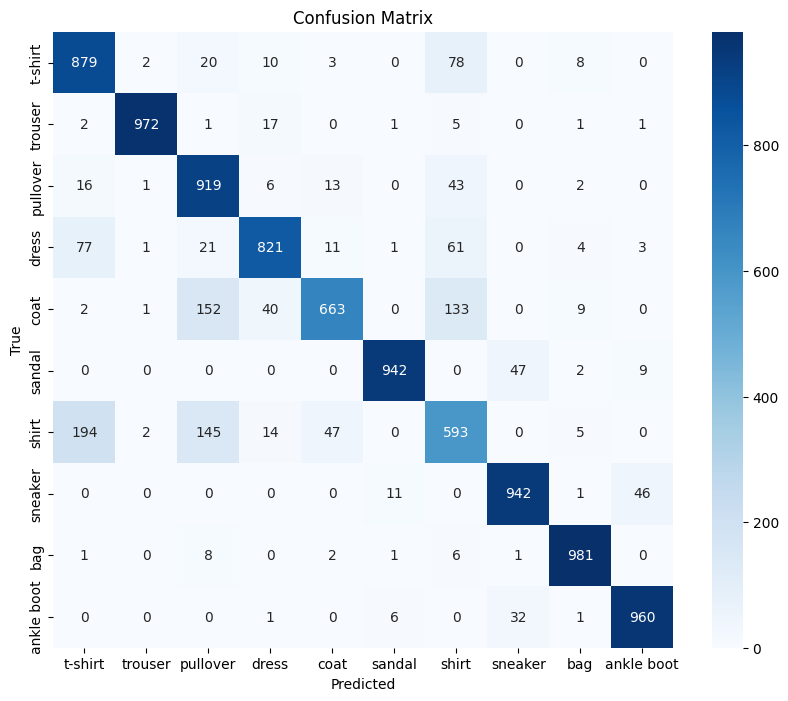

In [58]:
# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:
model_dir="../../models"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/fashion_mnist_cnn_model.keras")

# Gradio UI

In [61]:
import gradio as gr
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the trained model
model = tf.keras.models.load_model('../../models/fashion_mnist_cnn_model.keras')

# Class names corresponding to Fashion_mnist labels
class_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Preprocess the uploaded image
def preprocess_image(img):
    img = img.convert('L') # to grayscale
    img = img.resize((28,28)) # (28,28)
    img = np.array(img)
    
    # Normalize the image to the range [0, 1]
    img = img / 255.0

    # Add channel dimension
    img = np.expand_dims(img, axis=-1) # (28, 28, 1)
    
    # Expand dimensions to add batch size (1 image)
    img = np.expand_dims(img, axis=0).astype('float32') # (1, 28, 28, 1)
    
    return img

# Prediction function
def predict_image(img):
    if img is None:
        return None
    img = preprocess_image(img)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    return class_names[predicted_class]

demo = gr.Interface(fn=predict_image, 
                    inputs=gr.Image(type="pil", label="Upload an image"), 
                    outputs=gr.Label(num_top_classes=1, label="Predicted Class"),
                    title = "Fashion MNIST Classification",
                    description = "Upload an img and the model will classify it as one of the Fashion MNIST categories")

demo.launch()

* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
